<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/nebula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nebula Research**

In [32]:
!pip install astropy astroquery reproject lightkurve -q
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy import coordinates
import numpy as np
import matplotlib.pyplot as plt
from astroquery.ipac.irsa import Irsa
from astroquery.simbad import Simbad
from astroquery.ned import Ned
from astroquery.sdss import SDSS
from reproject import reproject_interp
from astropy.visualization import make_lupton_rgb
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import ZScaleInterval
%matplotlib inline

##### *Define object and get skycoordinates*

In [71]:
# Define object (Nebula name)
#object_name = 'M 27' # Orion Nebula
object_name = 'M 42' # Dumbbell Nebula
#object_name = 'NGC 602' # in Small Magellanic Cloud

In [72]:
# Get skycoordinates of desired object
galaxy = Simbad.query_object(object_name)
ra_hms = galaxy['ra'][0]
dec_dms = galaxy['dec'][0]
print(galaxy)
print("\n")
print("-"*60)
print("RA (h:m:s):", ra_hms)
print("DEC (d:m:s):", dec_dms)

main_id    ra     dec   ... coo_wavelength     coo_bibcode     matched_id
          deg     deg   ...                                              
------- ------- ------- ... -------------- ------------------- ----------
  M  42 83.8201 -5.3876 ...              X 2022A&A...661A..38P      M  42


------------------------------------------------------------
RA (h:m:s): 83.8201
DEC (d:m:s): -5.3876


In [73]:
# Set Coordinates

# When Simbad data (RA and DEC columns) are in sexagesimal/hour-angle format use:
# coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=('hourangle', 'deg'), frame='icrs')

# When Simbad data (RA and DEC columns) are in degrees (deg) format use:
coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit='deg', frame='icrs')

##### *Pull FITS infrared images via IRSA from Spitzer Telescope*

In [80]:
# How many science picture are therein spitzer_images?
spitzer_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection='spitzer_seip')
science_images_count = len(spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'])
print("Number of science images:", science_images_count)

Number of science images: 36


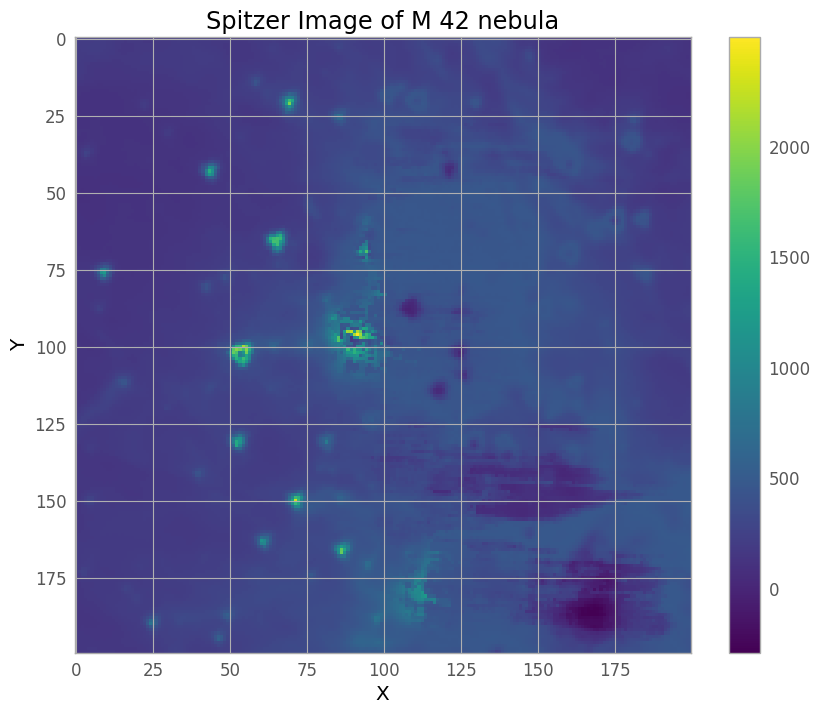

In [75]:
# Query IRSA database (from Spitzer telescope)
spitzer_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection='spitzer_seip')

# Open a cutout image for one of the science images
science_image = spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'][4]
with fits.open(science_image['access_url'], use_fsspec=True) as hdul:
    cutout = Cutout2D(hdul[0].data, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))

plt.figure(figsize=(10, 8))
plt.imshow(cutout.data, cmap='viridis')
plt.colorbar()
plt.title(f'Spitzer Image of {object_name} nebula')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

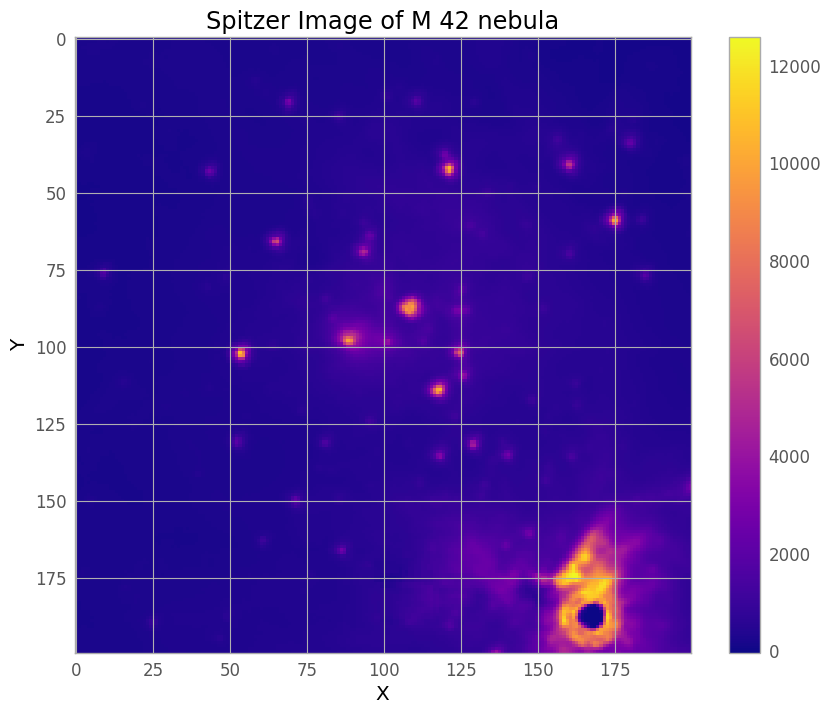

In [77]:
# Query IRSA database (from Spitzer telescope)
spitzer_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection='spitzer_seip')

# Open a cutout image for one of the science images
science_image = spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'][12]
with fits.open(science_image['access_url'], use_fsspec=True) as hdul:
    cutout = Cutout2D(hdul[0].data, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))

plt.figure(figsize=(10, 8))
plt.imshow(cutout.data, cmap='plasma')
plt.colorbar()
plt.title(f'Spitzer Image of {object_name} nebula')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

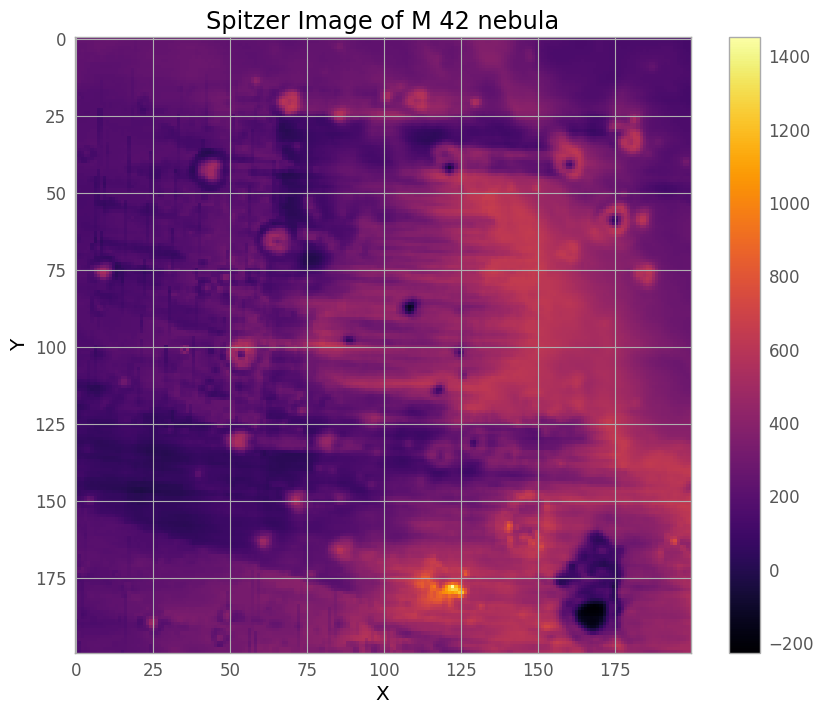

In [82]:
# Query IRSA database (from Spitzer telescope)
spitzer_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection='spitzer_seip')

# Open a cutout image for one of the science images
science_image = spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'][8]
with fits.open(science_image['access_url'], use_fsspec=True) as hdul:
    cutout = Cutout2D(hdul[0].data, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))

plt.figure(figsize=(10, 8))
plt.imshow(cutout.data, cmap='inferno')
plt.colorbar()
plt.title(f'Spitzer Image of {object_name} nebula')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
# Print the file information
hdul = fits.open(science_image['access_url'], use_fsspec=True)
hdul.info()

Filename: <class 'fsspec.implementations.http.HTTPFile'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      77   (1498, 2571)   float32   


In [ ]:
#  Access the primary HDU (Header/Data Unit) to get the data
primary_hdu = hdul[0]
data = primary_hdu.data
print(primary_hdu.header) # Display the header to learn more about the file
print(repr(hdul[0].header))  # Science data HDU header

SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -32 / Bits per pixel - floating point                NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 1498 / X axis length                                  NAXIS2  =                 2571 / Y axis length                                  ORIGIN  = 'Spitzer Super-Mosaic Pipeline' / Origin of these image data          CREATOR = 'Spitzer Science Center' / Creator of this FITS file                                                                                                            / TIME AND EXPOSURE INFORMATION                                                                                                                       TELESCOP= 'Spitzer '           / Name of Telescope                              INSTRUME= 'IRAC    '           / Name of Instrument                             CHNLNUM =                    3 / Instrum

In [ ]:
# Close the FITS file
hdul.close()

##### *Load data with FITS via SDSS*

In [36]:
# Check SDSS data availability for the region
# we reuse 'coord' from Simbad skycoordinates
# broaden radius to 2 arcmin to ensure the image field is captured
sdss_table = SDSS.query_region(coord, radius=2*u.arcmin)
print(sdss_table)

None


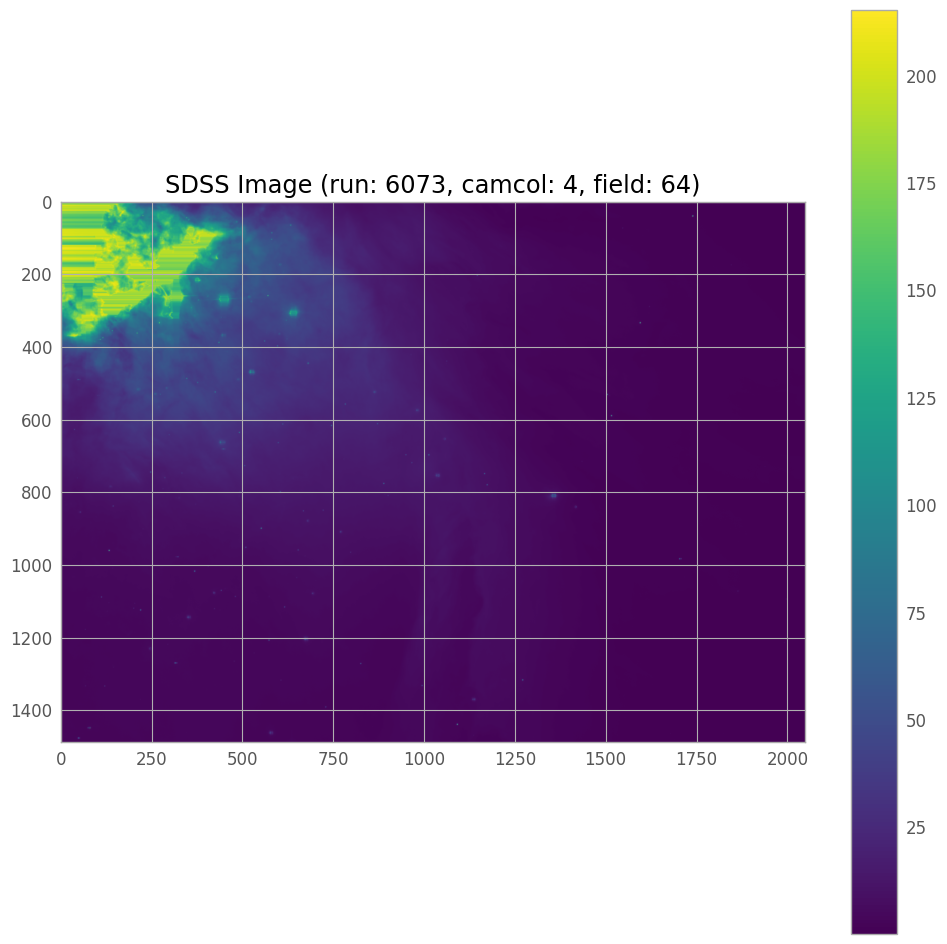

In [41]:
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

# Define the SDSS parameters from the result table (example)
run = 6073
rerun = 301
camcol = 4
field = 64

# Query the image using the specific SDSS parameters
try:
    images = SDSS.get_images(run=run, rerun=rerun, camcol=camcol, field=field, band='g') # change band

    # Display the first image result
    for image in images:
        plt.figure(figsize=(12, 12))
        plt.imshow(image[0].data, cmap='viridis')
        plt.colorbar()
        plt.title(f'SDSS Image (run: {run}, camcol: {camcol}, field: {field})')
        plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

* Right side (bright green area): This is likely a nebula or a dense region of gas and dust, which emits or reflects light prominently in the red spectrum. The bright color is due to higher pixel intensity in this region, indicating more light emission or reflection.
* Left side (darker regions): This area likely corresponds to the background sky or less dense regions. The faint, scattered dots might be stars or galaxies in the background.
* Overall structure: The image shows part of the Orion Nebula (or another object in that vicinity based on the coordinates you used), specifically the dense gas cloud structure emitting in the red filter.

Next Steps:
* You can adjust the filter band (e.g., 'r', 'g', 'i', 'z') to see how the object appears in different wavelengths.
* If you want more detailed information, you can overlay contours or perform image analysis using tools like astropy or photutils.

##### *Manually load data from FITS file*

In [ ]:
from astropy.io import fits

# Load the FITS file
fits_file = 'https://raw.githubusercontent.com/deltorobarba/repo/main/file_apStar-r5-2M05351021-0523215.fits'
hdulist = fits.open(fits_file)

# Check the structure of the FITS file
hdulist.info()

Filename: /root/.astropy/cache/download/url/b88f9fe4d76fb0fe2267219571a1bda7/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     105   ()      
  1                1 ImageHDU        12   (8575,)   float32   
  2                1 ImageHDU        12   (8575,)   float32   
  3                1 ImageHDU        12   (8575,)   int16   
  4                1 ImageHDU        12   (8575,)   float32   
  5                1 ImageHDU        12   (8575,)   float32   
  6                1 ImageHDU        12   (8575,)   float32   
  7                1 ImageHDU        12   (8575,)   float32   
  8                1 ImageHDU        29   (27,)   float64   
  9                1 BinTableHDU     75   1R x 29C   [30A, I, 4A, J, I, D, E, E, E, E, 2I, 2E, 2E, 2E, 2E, E, E, E, E, E, E, E, E, 401E, 401E, 401E, D, D, 401E]   


In [ ]:
header = hdulist[0].header
print(repr(header))

SIMPLE  =                    T /image conforms to FITS standard                 
BITPIX  =                   16 /bits per data value                             
NAXIS   =                    0 /number of axes                                  
EXTEND  =                    T /file may contain extensions                     
DATE    = '2014-08-09'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
OBJID   = '2M05351021-0523215' / Object ID                                      
J       =              11.3010 / 2MASS J magnitude                              
H       =              9.75500 / 2MASS H magnitude                              
K       =              8.96000 / 2MASS Ks magnitude                             
TARG1   =          -2147352576 / First APOGEE targeting flag (bitwise, see docs)
TARG2   =          -21474754